In [ ]:
#pip install openpyxl --upgrade

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
import collections
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import gc
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

In [ ]:
seed = 42

In [ ]:
# Select RDKit descriptors that we want
descr = Descriptors._descList[0:2] + Descriptors._descList[3:]
calc = [x[1] for x in descr]

In [ ]:
# get mols
def fingerprint(smiles):
        i=0
        fps_list = []
        chunksize = smiles.shape[0] // 381

        #for chunk in np.split(df, chunksize):
        for chunk in np.array_split(smiles, chunksize):
            #y = chunk['PUBCHEM_ACTIVITY_OUTCOME']
            mols = [Chem.MolFromSmiles(s) for s in chunk]
            del chunk
            fps = np.array(describe(mols))

            fps_list.append(fps)

        fps_train = np.concatenate(fps_list, axis=0)
        return fps_train

In [ ]:
# use mols to get molecular descriptors and fingerprints
def describe(mols):
    descrs = []
    for mol in mols:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048)
        fp_list = [int(x) for x in fp.ToBitString()]

        ds_n = [float(np.finfo(np.float32).max if v(mol) > np.finfo(np.float32).max else np.float32(v(mol))) for v in calc]
        descrs.append(fp_list + ds_n)

    return descrs

## ***Loading data***

In [ ]:
train = pd.read_excel('Train_with_smiles.xlsx')
valid = pd.read_excel('Valid_with_smiles.xlsx')
test = pd.read_excel('Test_with_smiles.xlsx')

data = pd.concat([train, test, valid], ignore_index=True)

cols = ['PUBCHEM_ACTIVITY_OUTCOME', 'smiles']
data = data[cols]
data = data.rename(columns={'PUBCHEM_ACTIVITY_OUTCOME': 'labels'})

label_map = {
    'Active': 1,
    'Inactive': 0,
}

data['labels'] = data['labels'].map(label_map)

In [ ]:
del train
del valid
del test
gc.collect()

41022

In [ ]:
train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

In [ ]:
train_df1, smaller_train_df1 = train_test_split(train_df1, test_size=0.01, random_state = seed, stratify=train_df1['labels'])

<AxesSubplot:>

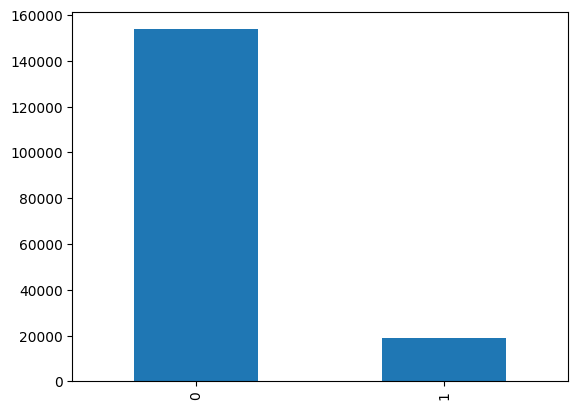

In [ ]:
train_df1['labels'].value_counts().plot.bar()

## **Getting molecular descriptors and fingerprints**

In [ ]:
smiles = smaller_train_df1['smiles']
y = smaller_train_df1['labels'].reset_index()

In [ ]:
fps_train = fingerprint(smiles)

In [ ]:
x = pd.DataFrame(fps_train)

In [ ]:
nan = np.where(np.asanyarray(np.isnan(x)))
nan_id = nan[0]
nan_id_unique = np.unique(nan_id)
nan_list = nan_id_unique.tolist()

y = y.drop(nan_list)
y = y.drop('index', axis = 1)
x = x.dropna()

In [ ]:
y_series = y['labels'].ravel()
y_series.shape

(1744,)

## **Hyper-parameter Tuning**

In [ ]:
# Define the parameter grid based on the given specifications
param_grid = {
    'mlpclassifier__alpha': [0.0001, 0.001],
    'mlpclassifier__max_iter': [200, 500, 1000],
    'mlpclassifier__activation': ['logistic', 'tanh'],
    'mlpclassifier__solver': ['lbfgs', 'sgd'],
    'mlpclassifier__learning_rate': ['constant', 'adaptive'],
}

# Create the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 1000, 1000))
#pipe = Pipeline(steps=[("scale", scale), ("mlp", mlp)])
pipeline = make_pipeline(MinMaxScaler(), mlp)
# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(x, y_series)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Access the best model
best_model = grid_search.best_estimator_

/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv

Best Hyperparameters: {'mlpclassifier__activation': 'tanh', 'mlpclassifier__alpha': 0.0001, 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__max_iter': 1000, 'mlpclassifier__solver': 'lbfgs'}


In [ ]:
scaler = MinMaxScaler()
scaler2 = MinMaxScaler().fit(x)

## Test evaluation

In [ ]:
smiles = test_df1['smiles']
y = test_df1['labels'].reset_index()

In [ ]:
fps_test = fingerprint(smiles)

In [ ]:
scaler = MinMaxScaler()
x = scaler2.transform(fps_test)
x = pd.DataFrame(x)

nan = np.where(np.asanyarray(np.isnan(x)))
nan_id = nan[0]
nan_id_unique = np.unique(nan_id)
nan_list = nan_id_unique.tolist()

y = y.drop(nan_list)
y = y.drop('index', axis = 1)
x = x.dropna()

In [ ]:
preds = best_model.predict(x)
probs = best_model.predict_proba(x)[:, 1]

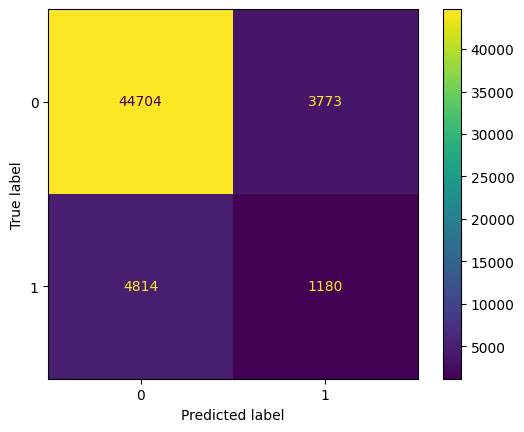

In [ ]:
cm = confusion_matrix(y, preds)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ccr = (specificity+ sensitivity)/2
ppv = (tp / (tp + fp))
npv = (tn / (tn + fn)) if (tn + fn) > 0 else 0

print('sen:{}'.format(sensitivity))
print('spe:{}'.format(specificity))
print('CCR:{}'.format(ccr))
print('ppv:{}'.format(ppv))
print('nen:{}'.format(npv))

sen:0.19686353019686353
spe:0.9221692761515771
CCR:0.5595164031742204
ppv:0.23823945083787604
nen:0.9027828264469486


In [ ]:
# Calculate the AUC score
auc_score = roc_auc_score(y, probs)

print("AUC-ROC Score:", auc_score)

AUC-ROC Score: 0.6067949615147256


## Ten runs:

In [ ]:
def runs(random_seed_list, data):

  ccr_list = []
  sen_list = []
  spe_list = []
  ppv_list = []
  npv_list = []
  auc_list = []

  for seed in random_seed_list:

        train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
        train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

        train_df1 = train_df1.reset_index(drop=True)
        valid_df1 = valid_df1.reset_index(drop=True)
        test_df1 = test_df1.reset_index(drop=True)

        # Separate majority and minority classes
        majority_class = train_df1[train_df1['labels'] == 0]
        minority_class = train_df1[train_df1['labels'] == 1]

        # Randomly sample majority class to match the number of minority class samples
        majority_undersampled = resample(majority_class, replace=False, n_samples=3*len(minority_class), random_state = seed)

        # Combine minority class and downsampled majority class
        train_df1 = pd.concat([minority_class, majority_undersampled])

        # train on smaller portion of the data
        train_df1, smaller_train_df1 = train_test_split(train_df1, test_size=0.01, random_state = seed, stratify=train_df1['labels'])

        # preparing data for training
        smiles = smaller_train_df1['smiles']
        y = smaller_train_df1['labels'].reset_index()
        fps_train = fingerprint(smiles)

        scaler = MinMaxScaler()
        scaler2 = scaler.fit(fps_train)
        x = scaler.transform(fps_train)
        x = pd.DataFrame(x)

        nan = np.where(np.asanyarray(np.isnan(x)))
        nan_id = nan[0]
        nan_id_unique = np.unique(nan_id)
        nan_list = nan_id_unique.tolist()

        y = y.drop(nan_list)
        y = y.drop('index', axis = 1)
        y = y['labels'].ravel()
        x = x.dropna()

        # fit the model
        best_model.fit(x, y)

        # prepare evaluation dataevaluation
        smiles = test_df1['smiles']
        y = test_df1['labels'].reset_index()
        fps_test = fingerprint(smiles)

        x = scaler2.transform(fps_test)
        x = pd.DataFrame(x)

        nan = np.where(np.asanyarray(np.isnan(x)))
        nan_id = nan[0]
        nan_id_unique = np.unique(nan_id)
        nan_list = nan_id_unique.tolist()

        y = y.drop(nan_list)
        y = y.drop('index', axis = 1)
        x = x.dropna()

        #predict and evaluate
        preds = best_model.predict(x)
        probs = best_model.predict_proba(x)[:, 1]

        cm = confusion_matrix(y, preds)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ccr = (specificity+ sensitivity)/2
        ppv = (tp / (tp + fp)) if (tp + fp) > 0 else 0
        npv = (tn / (tn + fn)) if (tn + fn) > 0 else 0

        auc_score = roc_auc_score(y, probs)

        ccr_list.append(ccr)
        sen_list.append(sensitivity)
        spe_list.append(specificity)
        ppv_list.append(ppv)
        npv_list.append(npv)
        auc_list.append(auc_score)

        print('finished run:', len(ccr_list))

  return ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list

In [ ]:
random_seed_list = [123, 80, 789, 567, 890, 345, 678, 901, 456, 12]

In [ ]:
ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list = runs(random_seed_list, data)

[04:05:50] WARNING: not removing hydrogen atom without neighbors
[04:05:51] WARNING: not removing hydrogen atom without neighbors
[04:05:51] WARNING: not removing hydrogen atom without neighbors
[04:05:51] WARNING: not removing hydrogen atom without neighbors


finished run: 1
finished run: 2


[04:26:16] WARNING: not removing hydrogen atom without neighbors
[04:26:18] WARNING: not removing hydrogen atom without neighbors
[04:26:18] WARNING: not removing hydrogen atom without neighbors
[04:26:18] WARNING: not removing hydrogen atom without neighbors


finished run: 3


[04:51:57] WARNING: not removing hydrogen atom without neighbors
[04:52:01] WARNING: not removing hydrogen atom without neighbors
[04:52:01] WARNING: not removing hydrogen atom without neighbors
[04:52:01] WARNING: not removing hydrogen atom without neighbors


finished run: 4
finished run: 5


[05:27:44] WARNING: not removing hydrogen atom without neighbors
[05:27:49] WARNING: not removing hydrogen atom without neighbors
[05:27:49] WARNING: not removing hydrogen atom without neighbors
[05:27:49] WARNING: not removing hydrogen atom without neighbors


finished run: 6
finished run: 7
finished run: 8
finished run: 9
finished run: 10


In [ ]:
# Calculate mean and standard deviation
ccr_mean = np.mean(ccr_list)
ccr_std = np.std(ccr_list)

sen_mean = np.mean(sen_list)
sen_std = np.std(sen_list)

spe_mean = np.mean(spe_list)
spe_std = np.std(spe_list)

ppv_mean = np.mean(ppv_list)
ppv_std = np.std(ppv_list)

npv_mean = np.mean(npv_list)
npv_std = np.std(npv_list)

auc_mean = np.mean(auc_list)
auc_std = np.std(auc_list)

# Print the results
print(f'Mean and Standard Deviation of CCR: {ccr_mean:.2f} ± {ccr_std:.2f}')
print(f'Mean and Standard Deviation of Sensitivity: {sen_mean:.2f} ± {sen_std:.2f}')
print(f'Mean and Standard Deviation of Specificity: {spe_mean:.2f} ± {spe_std:.2f}')
print(f'Mean and Standard Deviation of PPV: {ppv_mean:.2f} ± {ppv_std:.2f}')
print(f'Mean and Standard Deviation of NPV: {npv_mean:.2f} ± {npv_std:.2f}')
print(f'Mean and Standard Deviation of AUC: {auc_mean:.2f} ± {auc_std:.2f}')

Mean and Standard Deviation of CCR: 0.64 ± 0.01
Mean and Standard Deviation of Sensitivity: 0.43 ± 0.02
Mean and Standard Deviation of Specificity: 0.85 ± 0.01
Mean and Standard Deviation of PPV: 0.27 ± 0.02
Mean and Standard Deviation of NPV: 0.92 ± 0.00
Mean and Standard Deviation of AUC: 0.74 ± 0.01
